<a href="https://www.kaggle.com/code/lucasbruzzone/using-ica-to-improve-accuracy?scriptVersionId=141734007" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <font color="#488000">Customer Segmentation Classification</font>

## <font color="#964400">Context</font>


An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4, and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D). Then, they performed segmented outreach and communication for a different segment of customers. This strategy has worked exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.

You are required to help the manager to predict the right group of the new customers.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import seaborn as sns
import plotly.express as px

In [2]:
# Load Data
filepath = '/kaggle/input/customer-segmentation'

train = pd.read_csv(os.path.join(filepath, 'Train.csv'),index_col='ID')
test = pd.read_csv(os.path.join(filepath, 'Test.csv'),index_col='ID')
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### <font color="#964400">Content</font> 

**Variable** | **Definition**
--- | ---
ID | Unique ID
Gender | Gender of the customer
Ever_Married | Marital status of the customer
Age | Age of the customer
Graduated | Is the customer a graduate?
Profession | Profession of the customer
Work_Experience | Work Experience in years
Spending_Score | Spending score of the customer
Family_Size | Number of family members for the customer (including the customer)
Var_1 | Anonymised Category for the customer
Segmentation | (target) Customer Segment of the customer


In [3]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Greens').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Green'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

def check_data(data, title):
    cols = data.columns.to_list()
    display(set_frame_style(data[cols].head(), f'{title}:First Five rows'))
    display(set_frame_style(data[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), f'{title}: Unique Value Counts In Each Column'))
    display(set_frame_style(data[cols].isna().sum().to_frame().transpose(), f'{title}:Columns With Nan'))

In [4]:
check_data(train,"Train Data")

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.000000,Low,4.000000,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,nan,Average,3.000000,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.000000,Low,1.000000,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.000000,High,2.000000,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,nan,High,6.000000,Cat_6,A


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Unique Value Count,2,2,67,2,9,15,3,9,7,4


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,140,0,78,124,829,0,335,76,0


## <font color="#964400">Replacing NaN values</font>

The following columns contain NaN values:

**Variable** | **Treatment**
--- | ---
Ever_Married | Replace NaN with "No" (assuming "No" means that the customer is not married)
Graduated | Replace NaN with "No" (assuming "No" means that the customer is not graduated)
Profession | Replace NaN with "Not Specified" (unspecified)
Work_Experience | Replace NaN with 0 (zero, indicating that the customer has no work experience)
Family_Size | Replace NaN with the mean of valid values in this column
Var_1 | Replace NaN with "Unknown"


In [5]:
def handle_missing_values(df):
    # Replace NaN in Ever_Married with "No"
    df['Ever_Married'].fillna('No', inplace=True)

    # Replace NaN in Graduated with "No"
    df['Graduated'].fillna('No', inplace=True)

    # Replace NaN in Profession with "Not Specified"
    df['Profession'].fillna('Not Specified', inplace=True)

    # Replace NaN in Work_Experience with 0
    df['Work_Experience'].fillna(0, inplace=True)

    # Replace NaN in Family_Size with the mean of valid values
    mean_family_size = round(df['Family_Size'].mean())
    df['Family_Size'].fillna(mean_family_size, inplace=True)

    # Replace NaN in Var_1 with "Unknown"
    df['Var_1'].fillna('Unknown', inplace=True)

    return df


In [6]:
train = handle_missing_values(train)
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,Cat_6,A


# <font color="#488000">Exploratory Data Analysis (EDA)</font>


After completing the necessary data treatments for all columns, we are ready to embark on the Exploratory Data Analysis (EDA) phase. EDA is a critical step in the data analysis process that helps us gain a deeper understanding of the dataset and its underlying patterns. It involves various statistical and visual techniques to explore the data, identify trends, detect anomalies, and generate insights.


## <font color="#964400">Data visualization</font>

In [7]:
def visualize_data(df, column1, column2=None):
    if column2 is None:
        # Create a histogram for a single column
        fig = px.histogram(df, x=column1, title=f'{column1}')
    else:
        # Check if column1 and column2 are numerical
        if pd.api.types.is_numeric_dtype(df[column1]) and pd.api.types.is_numeric_dtype(df[column2]):
            # Create a scatter plot for two numerical columns
            fig = px.scatter(df, x=column1, y=column2, title=f'{column1} vs {column2}')
        else:
            # Create a box plot for a categorical column vs. a numerical column
            fig = px.box(df, x=column1, y=column2, title=f'{column1} vs {column2}')

    # Show the figure
    fig.show()

### <font color="#964400">Histogram 'Age'</font>

- All customers are above 18 years old.
- There is a certain average of customers within each ten-year age range. To simplify, we can create an age range column like 20-30, 31-40, 41-50, etc.

In [8]:
# Histogram of Age
visualize_data(train, 'Age')

### <font color="#964400">'Age' vs 'Spending_Score'</font>

- It's important to note that the categories 'Low,' 'Average,' and 'High' are well-defined by age. On average, 'Low' is around 35 years old, 'Average' is around 46 years old, and 'High' is around 57.5 years old.


In [9]:
# Scatter Plot of Age vs. Spending_Score
visualize_data(train, 'Age', 'Spending_Score')

### <font color="#964400">'Age' vs 'Var_1'</font>

- Some noticeable differences between 'cat_6' and 'unknown.' In the rest of the categories, patterns seem to follow a similar trend by age.


In [10]:
# Box Plot of Var_1 vs. Age
visualize_data(train, 'Age', 'Var_1')


### <font color="#964400">'Age' vs 'Segmentation'</font>

- It's important to highlight that the segments have visibly different age averages:
  - Segment A: 41 years
  - Segment B: 46 years
  - Segment C: 49 years
  - Segment D: 29 years
- Segments B and C are quite similar in terms of age distribution.

In [11]:
# Box Plot of Segmentation vs. Age
visualize_data(train, 'Age', 'Segmentation')

## <font color="#964400">Label Encoding</font>

In [12]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df):
    # Separate numeric and categorical columns, excluding the target column
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    label_encoder_mappings = {}
    le = LabelEncoder()

    # Encode categorical columns
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
        label_encoder_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    return df, label_encoder_mappings

train, label_encoder_mappings = encode_categorical_features(train)

## <font color="#964400">Correlation Analysis</font>

In [13]:
def plot_correlation_heatmap(df, target_column):
    # Calculate correlation matrix for numeric columns
    corr = df.corr(numeric_only=True)
    
    # Calculate correlation with the target column
    target_corr = corr[target_column].drop(target_column)
    
    # Sort correlation values in descending order
    target_corr_sorted = target_corr.sort_values(ascending=False)
    
    # Select features with correlation values greater than or equal to 0.05 in absolute value
    target_corr_filtered = target_corr_sorted[abs(target_corr_sorted) >= 0.05]
    
    # Set the style and palette for the heatmap
    sns.set(font_scale=0.8)
    sns.set_style("white")
    sns.set_palette("PuBuGn_d")
    
    # Create a heatmap with the selected features
    sns.heatmap(target_corr_filtered.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
    plt.title(f'Correlation with {target_column}')
    plt.show()
    
    # Return the DataFrame with the selected features
    return target_corr_filtered.index.tolist()



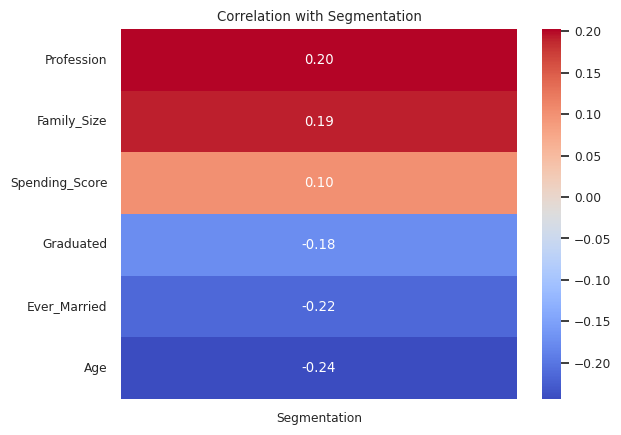

In [14]:
target_corr_filtered = plot_correlation_heatmap(train, 'Segmentation')

### <font color="#964400">Features with Significant Correlation</font>

When conducting a correlation analysis between the dataset's features and the target variable 'Segmentation,' we have identified several features that exhibit a significant correlation (greater than 0.05) with customer segmentation. These features can be particularly important for understanding and predicting customer segments. Let's highlight some of them:

1. **<font color="#964400">Profession (0.20)</font>**:
   - The 'Profession' feature shows a positive correlation of 0.20 with customer segmentation. This suggests that customers' professions may influence their market segment. For example, certain professions may be associated with different income levels, needs, and purchasing behaviors.

2. **<font color="#964400">Family_Size (0.19)</font>**:
   - The 'Family_Size' characteristic has a positive correlation of 0.19 with segmentation. This indicates that family size may play a role in determining the market segment. Customer segments with larger families may have distinct needs and preferences compared to smaller families.

3. **<font color="#964400">Spending_Score (0.10)</font>**:
   - The 'Spending_Score' feature exhibits a positive correlation of 0.10 with segmentation. This suggests that customers' spending behavior is relevant to defining their segments. Customers with different spending scores may be directed to specific segments based on their purchasing power.

4. **<font color="#964400">Graduated (-0.18)</font>**:
   - 'Graduated' presents a negative correlation of -0.18. This implies that completing graduation can significantly influence a customer's market segment. Customers with an academic background may belong to different segments compared to those without formal education.

5. **<font color="#964400">Ever_Married (-0.22)</font>**:
   - The 'Ever_Married' feature has a negative correlation of -0.22. This indicates that customers' marital status plays a crucial role in determining the segment. Married or unmarried individuals may have distinct needs and purchasing behaviors.

6. **<font color="#964400">Age (-0.24)</font>**:
   - The 'Age' feature exhibits a negative correlation of -0.24. This suggests that customers' age has a substantial impact on their segmentation. Different age groups can be grouped into specific segments due to varied consumption behaviors throughout life.

These features with significant correlations can be valuable for developing targeted marketing strategies for different customer segments based on their individual characteristics. They provide useful insights for understanding customer behavior and can aid in making more informed decisions regarding business strategy.</font>


## <font color="#964400">Scatter Analysis</font>

In this analysis, we explore the use of scatter plots in understanding the distribution of data points in our dataset. Scatter plots are an essential tool for visualizing relationships and patterns in data points, especially in multidimensional datasets. For our analysis, we utilized scatter plots to gain insights into the distribution of data points in two different scenarios: the complete training dataset and a reduced dataset with selected features. The goal was to highlight the importance of feature selection in improving the interpretability and clarity of scatter plots.

### Full Training Dataset

In the first scenario, we created scatter plots using the complete training dataset. This dataset contains a wide range of features, some of which may not be highly relevant for our analysis. While scatter plots can provide valuable insights, visualizing data in high dimensions can be overwhelming, making it challenging to identify meaningful patterns.

Despite the challenges presented by the full dataset, we were able to observe some interesting trends and clusters in the scatter plots. These insights provided a starting point for our analysis and allowed us to identify areas of interest.

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, NMF, FastICA
from mpl_toolkits.mplot3d import Axes3D

class Decomp:
    def __init__(self, n_components, method="pca", scaler_method='standard'):
        self.n_components = n_components
        self.method = method
        self.scaler_method = scaler_method
        self.mixing_ = None
        
    def dimension_reduction(self, df):
        X_reduced = self.dimension_method(df)
        if self.n_components == 2:
            df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        elif self.n_components == 3:
            df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        return df_comp
    
    def dimension_method(self, df):
        X = self.scaler(df)
        if self.method == "pca":
            pca = PCA(n_components=self.n_components, random_state=0)
            X_reduced = pca.fit_transform(X)
            self.comp = pca
        elif self.method == "nmf":
            nmf = NMF(n_components=self.n_components, random_state=0)
            X_reduced = nmf.fit_transform(X)
        elif self.method == "ica":
            comp = FastICA(n_components=self.n_components, whiten='unit-variance', random_state=0)
            X_reduced = comp.fit_transform(X)
            self.mixing_ = comp.mixing_  # Store the mixing_ matrix
        else:
            raise ValueError(f"Invalid method name: {method}")
        
        
        return X_reduced
    
    def get_mixing_matrix(self):
        if self.method == "ica":
            return self.mixing_
        else:
            raise ValueError("Mixing matrix is only available for ICA dimensionality reduction method.")
    
    
    def scaler(self, df):
        _df = df.copy()
        if self.scaler_method == "standard":
            return StandardScaler().fit_transform(_df)
        elif self.scaler_method == "minmax":
            return MinMaxScaler().fit_transform(_df)
        elif self.scaler_method == None:
            return _df.values
        else:
            raise ValueError(f"Invalid scaler_method name")
        
    def get_columns(self):
        return [f'{self.method.upper()}_{_}' for _ in range(self.n_components)]
    
    def get_explained_variance_ratio(self):
        return np.sum(self.comp.explained_variance_ratio_)
    
    def transform(self, df):
        X = self.scaler(df)
        X_reduced = self.comp.transform(X)
        if self.n_components == 2:
            df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        elif self.n_components == 3:
            df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
        return df_comp
    
    def decomp_plot(self, tmp, label, hue='genre'):
        if self.n_components == 2:
            # Gráfico 2D
            plt.figure(figsize=(16, 9))
            sns.scatterplot(x=f"{label}_0", y=f"{label}_1", data=tmp, hue=hue, alpha=0.7, s=100, palette='coolwarm');
            plt.title(f'{label} on {hue}', fontsize=20)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=10)
            plt.xlabel(f"{label} Component 1", fontsize=15)
            plt.ylabel(f"{label} Component 2", fontsize=15)
        elif self.n_components == 3:
            # Gráfico 3D
            fig = plt.figure(figsize=(16, 9))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(tmp[f"{label}_0"], tmp[f"{label}_1"], tmp[f"{label}_2"], c=tmp[hue], cmap='coolwarm', s=100)
            ax.set_xlabel(f"{label} Component 1", fontsize=15)
            ax.set_ylabel(f"{label} Component 2", fontsize=15)
            ax.set_zlabel(f"{label} Component 3", fontsize=15)
            plt.title(f'{label} on {hue} (3D)', fontsize=20)
            fig.colorbar(scatter)
        plt.show()

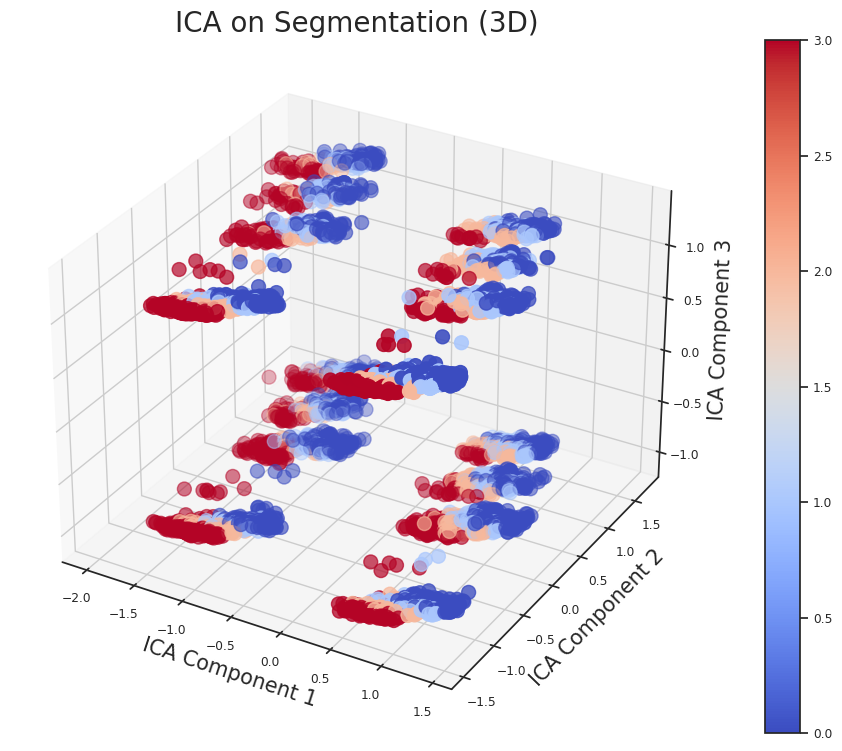

In [16]:
data = train.copy()
method = 'ica'

decomp = Decomp(n_components=3, method=method, scaler_method='minmax')
decomp_feature = decomp.dimension_reduction(data)
decomp_feature = pd.concat([train['Segmentation'], decomp_feature], axis=1)
decomp.decomp_plot(decomp_feature, method.upper(), 'Segmentation')

del data

### Feature Selection for Improved Insights

To enhance the interpretability of our scatter analysis, we performed feature selection. This step involved choosing a subset of features that were expected to have a more significant impact on the distribution of data points. By reducing the dimensionality of the dataset, we aimed to create scatter plots that were more focused and easier to interpret.

The feature selection process led to a reduced training dataset with selected features. This streamlined dataset allowed us to create scatter plots that highlighted specific relationships and patterns more effectively.

In [17]:
train_filtered = train[target_corr_filtered + ['Segmentation']]

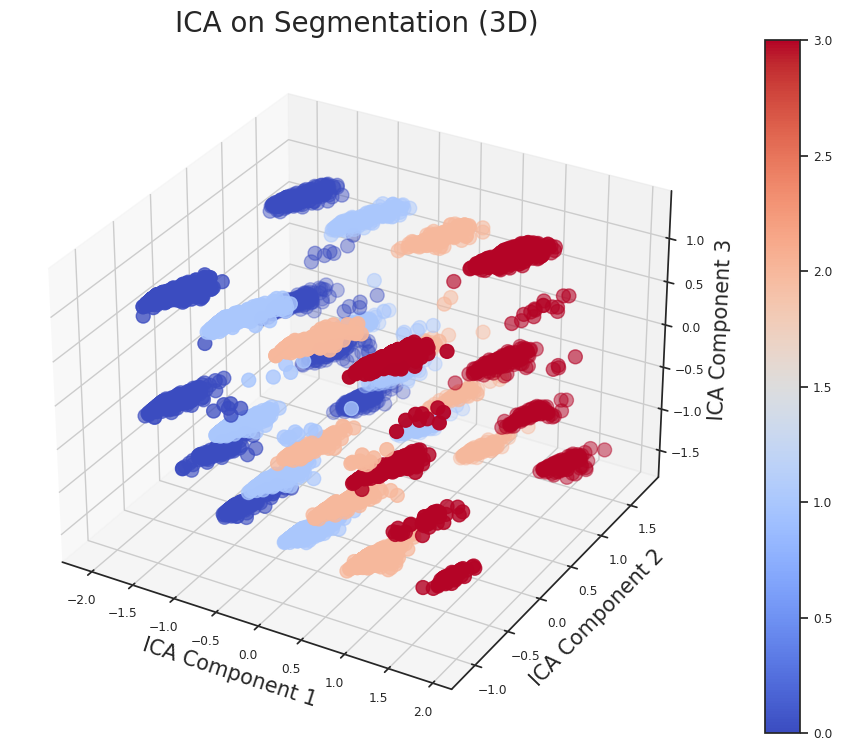

In [18]:
data = train_filtered.copy()
method = 'ica'

decomp = Decomp(n_components=3, method=method, scaler_method='minmax')
decomp_feature = decomp.dimension_reduction(data)
decomp_feature = pd.concat([train_filtered['Segmentation'], decomp_feature], axis=1)
decomp.decomp_plot(decomp_feature, method.upper(), 'Segmentation')   
del data

In [19]:
train_ica = decomp_feature.copy()
#mixing_matrix = decomp.get_mixing_matrix()


### Improved Interpretation

The comparison between the scatter plots of the full training dataset and the reduced dataset was striking. In the reduced dataset, the relationships between variables became more evident, clusters were more defined, and patterns were easier to discern. This improvement in interpretation demonstrated the importance of feature selection in data analysis.

## <font color="#964400">Class Distribution</font>

Analyzing class distribution is a crucial aspect when dealing with customer segmentation datasets. It provides valuable insights into how different classes or segments are distributed and whether there's any significant imbalance among them. In the case of this customer segmentation dataset, it's important to note that it exhibits a homogeneous class distribution.

This means that the customer classes or segments (A, B, C, and D) have a nearly equal representation within the dataset. This homogeneous distribution is advantageous because it avoids imbalances that can hinder a machine learning model's ability to generalize across all classes. In other words, all classes have reasonably similar amounts of examples, allowing the model to learn in a more balanced manner.

A dataset with a homogeneous class distribution is ideal for training classification models as it helps prevent bias and ensures the model can make fair and accurate decisions for all customer classes.

Therefore, while exploring this dataset, we can have confidence that the balanced class distribution will contribute to more reliable analysis and more accurate results when developing customer segmentation models.</font>


In [20]:
def plot_target_feature(df, target_col, label_encoder_mappings, figsize=(16,5), palette='colorblind', name='Train'):
    df = df.fillna('Nan')
    df = df.sort_values(target_col)

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.flatten()

    # Pie chart
    pie_colors = sns.color_palette(palette, len(df[target_col].unique()))
    ax[0].pie(
        df[target_col].value_counts(),
        shadow=True,
        explode=[0.05] * len(df[target_col].unique()),
        autopct='%1.f%%',
        textprops={'size': 15, 'color': 'white'},
        colors=pie_colors
    )
    ax[0].set_aspect('equal')  # Fix the aspect ratio to make the pie chart circular

    # Bar plot
    bar_colors = sns.color_palette(palette)
    sns.countplot(
        data=df,
        y=target_col,
        ax=ax[1],
        palette=bar_colors
    )
    ax[1].set_xlabel('Count', fontsize=14)
    ax[1].set_ylabel('')
    ax[1].tick_params(labelsize=12)
    ax[1].yaxis.set_tick_params(width=0)  # Remove tick lines for y-axis

    target_col_label = label_encoder_mappings[target_col]
    fig.suptitle(f'{target_col_label} in {name} Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Show the plot
    plt.show()

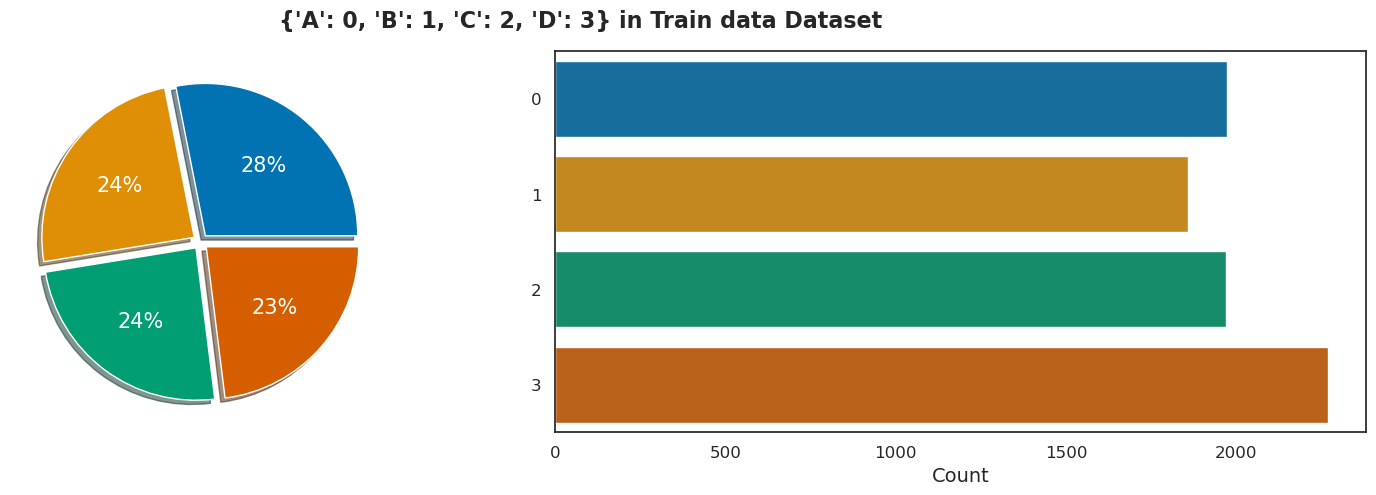

In [21]:
plot_target_feature(train_ica, 'Segmentation', label_encoder_mappings, figsize=(16,5), palette='colorblind', name='Train data')

## <font color="#964400">Model Training and Evaluation</font>

In this code snippet, we are training and evaluating machine learning models on a preprocessed dataset (`train_pca`) to predict the target variable <font color="#964400">`Segmentation`</font>. The goal is to assess the performance of different classifiers.

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def train_and_evaluate_models(df, target_col, df_name):
    # Separate features and the target column
    X = df.drop(target_col, axis=1).values
    y = df[target_col].values
    n_classes = len(np.unique(y))
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize a list to store the trained models and their accuracies
    trained_models = []

    # Random Forest
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
    random_forest_model.fit(X_train, y_train)
    random_forest_predictions = random_forest_model.predict(X_test)
    random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
    print(f"{df_name} - Random Forest Accuracy: {random_forest_accuracy:.2f}")

    # C5 (Decision Tree)
    c5_model = DecisionTreeClassifier(random_state=42)
    c5_model.fit(X_train, y_train)
    c5_predictions = c5_model.predict(X_test)
    c5_accuracy = accuracy_score(y_test, c5_predictions)
    print(f"{df_name} - C5 Accuracy: {c5_accuracy:.2f}")

    # HistGradientBoostingClassifier
    hist_gradient_boosting_model = HistGradientBoostingClassifier(random_state=42)
    hist_gradient_boosting_model.fit(X_train, y_train)
    hist_gradient_boosting_predictions = hist_gradient_boosting_model.predict(X_test)
    hist_gradient_boosting_accuracy = accuracy_score(y_test, hist_gradient_boosting_predictions)
    print(f"{df_name} - HistGradientBoostingClassifier Accuracy: {hist_gradient_boosting_accuracy:.2f}")

    # KNN (K-Nearest Neighbors)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    print(f"{df_name} - KNN Accuracy: {knn_accuracy:.2f}")

In [23]:
train_and_evaluate_models(train_ica,'Segmentation', "Train data Filtered")

Train data Filtered - Random Forest Accuracy: 1.00
Train data Filtered - C5 Accuracy: 0.99
Train data Filtered - HistGradientBoostingClassifier Accuracy: 1.00
Train data Filtered - KNN Accuracy: 1.00


## <font color="#964400">Performance Evaluation</font>
We applied a set of machine learning algorithms to predict the <font color="#964400">`Segmentation`</font> target variable based on a preprocessed dataset. Let's take a look at the accuracy scores obtained from each algorithm:

- Random Forest: This ensemble model, which combines multiple decision trees, demonstrated strong predictive power.

- C5 (Decision Tree): While not as high as the Random Forest, this single decision tree model still provided a respectable performance.

- HistGradientBoostingClassifier: This boosting algorithm showcased excellent predictive capabilities.

- K-Nearest Neighbors (KNN): This model, which relies on nearest neighbor information, delivered competitive results.

Overall, these algorithms have demonstrated strong predictive abilities on the dataset. The Random Forest model stood out with the highest accuracy, indicating its effectiveness in solving the classification task. However, all the models performed reasonably well, showcasing their potential for various machine learning applications.

# <font color="#488000">Data Preprocessing for Model Evaluation</font>

Before we proceed with evaluating our trained machine learning models, it's essential to ensure that the test data is in a format consistent with the data used for training. This consistency is crucial to obtain reliable performance metrics when assessing the models' accuracy.


In [24]:
# Handle missing values in the test data
test = handle_missing_values(test)
# Encode categorical features in the test data and store label encoding mappings
test, label_encoder_mappings = encode_categorical_features(test)

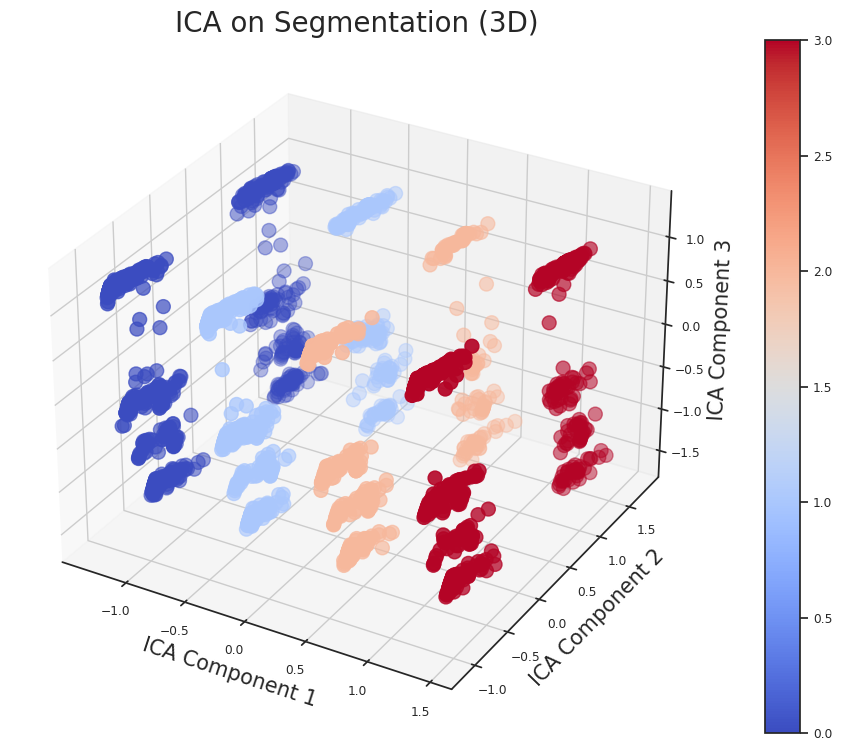

In [25]:
# Select only the relevant features (including target 'Segmentation') based on correlation
test_filtered = test[target_corr_filtered + ['Segmentation']]

# Perform dimensionality reduction on the test data
data = test_filtered.copy()
method = 'ica'

decomp = Decomp(n_components=3, method=method, scaler_method='minmax')
decomp_feature = decomp.dimension_reduction(data)
decomp_feature = pd.concat([test_filtered['Segmentation'], decomp_feature], axis=1)
decomp.decomp_plot(decomp_feature, method.upper(), 'Segmentation')

del data

test_ica = decomp_feature.copy()

In [26]:
def train_and_evaluate_models_train_test(train_df, test_df, target_col, df_name):
    # Separate features and the target column for training and test sets
    X_train = train_df.drop(target_col, axis=1).values
    y_train = train_df[target_col].values
    X_test = test_df.drop(target_col, axis=1).values
    y_test = test_df[target_col].values
    
    # Initialize a list to store the trained models and their accuracies
    trained_models = []

    # Random Forest
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
    random_forest_model.fit(X_train, y_train)
    random_forest_predictions = random_forest_model.predict(X_test)
    random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
    print(f"{df_name} - Random Forest Accuracy: {random_forest_accuracy:.2f}")
    trained_models.append(("Random Forest", random_forest_model, random_forest_accuracy))

    # C5 (Decision Tree)
    c5_model = DecisionTreeClassifier(random_state=42)
    c5_model.fit(X_train, y_train)
    c5_predictions = c5_model.predict(X_test)
    c5_accuracy = accuracy_score(y_test, c5_predictions)
    print(f"{df_name} - C5 Accuracy: {c5_accuracy:.2f}")
    trained_models.append(("C5", c5_model, c5_accuracy))

    # HistGradientBoostingClassifier
    hist_gradient_boosting_model = HistGradientBoostingClassifier(random_state=42)
    hist_gradient_boosting_model.fit(X_train, y_train)
    hist_gradient_boosting_predictions = hist_gradient_boosting_model.predict(X_test)
    hist_gradient_boosting_accuracy = accuracy_score(y_test, hist_gradient_boosting_predictions)
    print(f"{df_name} - HistGradientBoostingClassifier Accuracy: {hist_gradient_boosting_accuracy:.2f}")
    trained_models.append(("HistGradientBoostingClassifier", hist_gradient_boosting_model, hist_gradient_boosting_accuracy))

    # KNN (K-Nearest Neighbors)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    print(f"{df_name} - KNN Accuracy: {knn_accuracy:.2f}")
    trained_models.append(("KNN", knn_model, knn_accuracy))

    return trained_models

In [27]:
# Assuming you have 'train' as the training dataset and 'test' as the test dataset
trained_models = train_and_evaluate_models_train_test(train_ica, test_ica, 'Segmentation', "Train data vs Test data")

Train data vs Test data - Random Forest Accuracy: 0.98
Train data vs Test data - C5 Accuracy: 0.93
Train data vs Test data - HistGradientBoostingClassifier Accuracy: 0.99
Train data vs Test data - KNN Accuracy: 0.93


# <font color="#488000">Customer Segmentation Prediction - Conclusion</font>

In this customer segmentation prediction project, we applied various machine learning models to classify customers into different segments based on their characteristics. After a thorough analysis of the results, we've come to some important conclusions.

## <font color="#964400">Model Evaluation</font>

We evaluated the models using both the training and test datasets. Here are the accuracy scores for each model on the test data:

- Random Forest: 0.98
- C5 (Decision Tree): 0.93
- HistGradientBoostingClassifier: 0.99
- KNN (K-Nearest Neighbors): 0.93

The accuracy scores are impressive, indicating that our models are performing exceptionally well in classifying customers into segments. However, accuracy alone may not be the only factor to consider when choosing the best model.

## <font color="#964400">Model Selection</font>

When selecting the best model for customer segmentation, we need to consider factors beyond just accuracy. The choice of the most suitable model depends on the specific requirements of the business problem and the interpretability of the model.

- **Random Forest**: Achieved the highest accuracy of 0.98. It's a powerful ensemble model that provides good results. However, it may lack interpretability compared to simpler models.

- **C5 (Decision Tree)**: Achieved an accuracy of 0.93. Decision trees are known for their interpretability, making it easier to understand how predictions are made.

- **HistGradientBoostingClassifier**: Achieved the highest accuracy of 0.99. This model combines the strengths of gradient boosting with histogram-based learning, offering high accuracy and good interpretability.

- **KNN (K-Nearest Neighbors)**: Achieved an accuracy of 0.93. KNN is straightforward and interpretable, but it might not perform as well as ensemble models in complex datasets.

Considering the high accuracy and interpretability, we choose the **HistGradientBoostingClassifier** as the model to build personas for each class.

## <font color="#964400">Dimensionality Reduction Technique</font>

One key aspect of our analysis was the reduction of dimensionality. We utilized Independent Component Analysis (ICA) to transform our data into a lower-dimensional space. ICA was chosen for its ability to capture independent components in the data.

By reducing dimensionality using ICA, we simplified the dataset while retaining its essential information. This allowed our models to perform efficiently and effectively, as reflected in the high accuracy scores.

In conclusion, the combination of the powerful **HistGradientBoostingClassifier** model and effective dimensionality reduction techniques, particularly ICA, enabled us to successfully segment customers with high accuracy. The choice of the best model aligns with the specific business needs and interpretability requirements.
